In [1]:
!pip install helical

In [2]:
import logging
import warnings
from datasets import load_dataset

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

dataset = load_dataset("helical-ai/yolksac_human", split="train[:10%]", trust_remote_code=True, download_mode="reuse_cache_if_exists")
labels = dataset["LVL1"]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [3]:
from helical.utils import get_anndata_from_hf_dataset

ann_data = get_anndata_from_hf_dataset(dataset)
ann_data

INFO:helical:Caduceus not available: If you want to use this model, ensure you have a CUDA GPU and have installed the optional helical[mamba-ssm] dependencies.


AnnData object with n_obs × n_vars = 2534 × 37318
    obs: 'LVL1', 'LVL2', 'LVL3'
    var: 'gene_name'

In [4]:
from helical import models
import pkgutil
for model in pkgutil.iter_modules(models.__path__):
    if model.name != "base_models" and model.name != "fine_tune":
        print("Model :",model.name)

Model : caduceus
Model : classification
Model : geneformer
Model : genept
Model : helix_mrna
Model : hyena_dna
Model : mamba2_mrna
Model : scgpt
Model : uce


In [5]:
from helical import Geneformer, GeneformerConfig
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_config = GeneformerConfig(batch_size=10,device=device)
geneformer = Geneformer(configurer=model_config)

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/geneformer/v1
INFO:helical.utils.downloader:Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v1/gene_median_dictionary.pkl'
Downloading: 100%|██████████| 941k/941k [00:02<00:00, 434kB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v1/gene_median_dictionary.pkl'
INFO:helical.utils.downloader:Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v1/token_dictionary.pkl'
Downloading: 100%|██████████| 788k/788k [00:00<00:00, 1.19MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v1/token_dictionary.pkl'
INFO:helical.utils.downloader:Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v1/ensembl_mapping_dict.pkl'
Downloading: 100%|██████████| 3.96M/3.96M [00:01<00:00, 2.98MB/s]
INFO:helical.utils.do

In [6]:
dataset = geneformer.process_data(ann_data[:100], gene_names="gene_name")

INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.download_cache:Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.110.gtf.gz from URL https://ftp.ensembl.org/pub/release-110/gtf/homo_sapiens/Homo_sapiens.GRCh38.110.gtf.gz
INFO:datacache.download:Downloading https://ftp.ensembl.org/pub/release-110/gtf/homo_sapiens/Homo_sapiens.GRCh38.110.gtf.gz to /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.110.gtf.gz
INFO:pyensembl.download_cache:Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz from URL https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
INFO:datacache.download:Downloading https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz to /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz
INFO:pyensembl.download_cache:Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sa

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.


In [7]:
embeddings = geneformer.get_embeddings(dataset)

print(embeddings.shape)

INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


(100, 512)


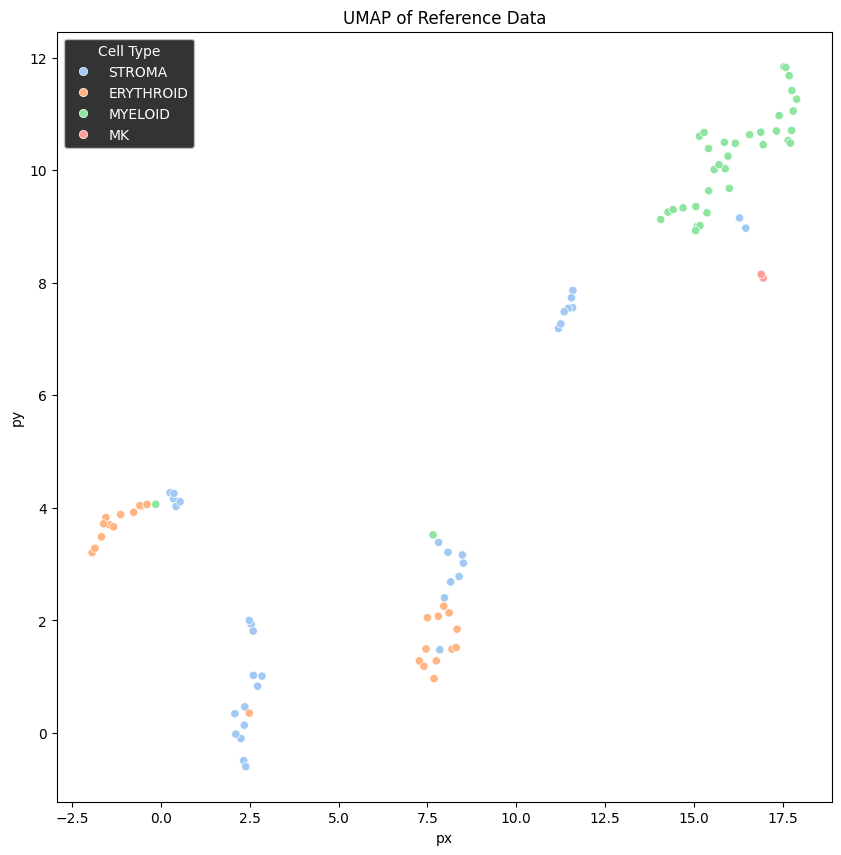

In [8]:
import umap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=4)
mapper = reducer.fit(embeddings)

labels = labels[:100]

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")
plt.title('UMAP of Reference Data')
plt.show()